In [1]:
import os
import re
import glob
import pandas as pd
import scipy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from Bio.Blast import NCBIWWW
from Bio import SeqIO
from Bio import SearchIO
import seaborn as sns
from matplotlib import gridspec
from itertools import combinations
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import time
import os.path
from os import path

# function to create colour dictionaries from a colour map and a list of items
def colourDict(data,cmap=mpl.cm.viridis,sort=False):
    """
    returns a dictionary of unique data_items:colour hex code, normalised
    takes a list of items and a cmap as mpl.cm.name. If sort = False, the function takes an ordered list of unique elements
    """
    cmap=cmap # default viridis
    data_unique=data if sort == False else list(set(data)) # includes nan values as a key. That is desirable sometimes
    norm = mpl.colors.Normalize(vmin=0, vmax=len(data_unique))
    colors = [cmap(norm(value)) for value in range(len(data_unique))]
    return dict(zip(data_unique,colors))

# Pairwise Fst calculations from poolfstats

In [60]:
glbfst = pd.read_csv('./GM_SNPs_Fst_2023/pairwisefst_minmaf5_2023.txt', sep = '\t') #, index_col = 'pairwisefst')
# NaN in diagonal have been replaced by zeros
labeldict = {'P13454_101':'Gm\nmacrostachys A',
             'P13454_102':'Gm\nmacrostachys S',
             'P13454_103':'Gm\nacaulis S',
             'P13454_104':'Gm\nacaulis A'}
glbfst['samples'] = glbfst['pairwisefst'].map(labeldict)
glbfstlab = glbfst.rename(columns = labeldict)
glbfstlab.set_index('samples', inplace = True)
glbfstlab.drop(columns = 'pairwisefst', inplace = True)
glbfstlab

,Gm\nmacrostachys A,Gm\nmacrostachys S,Gm\nacaulis S,Gm\nacaulis A
samples,,,,
Gm\nmacrostachys A,0.000000,-0.004520,0.106826,0.142671
Gm\nmacrostachys S,-0.004520,0.000000,0.118267,0.155736
Gm\nacaulis S,0.106826,0.118267,0.000000,0.001806
Gm\nacaulis A,0.142671,0.155736,0.001806,0.000000


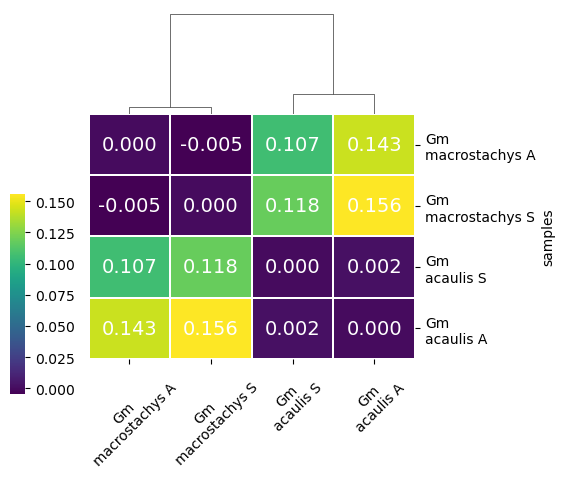

In [61]:
# fig,ax=plt.subplots(figsize=(5,5),facecolor='w')

labelcolor='#4f4f4f'

# 'fontweight':'bold' #e3e3e3
hm = sns.clustermap(glbfstlab, figsize = (5,5), row_cluster = False, dendrogram_ratio = (.01, .3),
     cbar_pos = (-0.12, .2, .03, .4), cmap = 'viridis', linewidths = .75,
     annot = True, fmt = '.3f', annot_kws = {'fontsize':14,'color':'w'})

plt.setp(hm.ax_heatmap.xaxis.get_majorticklabels(), rotation=45)

# plt.savefig('../figures//Cor_allvariables_20220812.pdf',dpi=300,bbox_inches='tight')
plt.show()

# Process files and create dataframe

In [62]:
# upload files
path=os.getcwd()
ext='./GM_SNPs_Fst_2023/*glb_sliding10m.txt'

data=pd.DataFrame(columns=['chr','position','cumulatedposition','multilocusfst','pair'])

for filename in glob.glob(os.path.join(path,'%s'%(ext))):
    pair=filename.split('/')[-1].split('glb')[0]
    tempdata=pd.read_csv(filename,names=['chr','position','cumulatedposition','multilocusfst'],
                         skiprows=1,sep=' ')
    tempdata['pair']=[pair]*len(tempdata)
    data=pd.concat([data,tempdata], sort=True)
data.reset_index(inplace=True)
data

,index,chr,cumulatedposition,multilocusfst,pair,position
0,0,NC_025997.1_RagTag_RagTag,23524883,-0.014640,pools12,23524883
1,1,NC_026004.1_RagTag_RagTag,36946161,0.016542,pools12,13421278
2,2,NC_026007.1_RagTag_RagTag,47938388,-0.004853,pools12,10992227
3,3,NC_026007.1_RagTag_RagTag,47938429,-0.026491,pools12,10992268
4,4,NODE_100003_length_1654_cov_23.324578,47940000,-0.041583,pools12,1571
...,...,...,...,...,...,...
170737,28452,NW_011587330.1_RagTag_RagTag,84827954,0.006760,pools34,9443
170738,28453,NW_011588234.1_RagTag_RagTag,84829008,-0.012755,pools34,1054
170739,28454,NW_011588234.1_RagTag_RagTag,84829031,-0.017269,pools34,1077
170740,28455,NW_011588234.1_RagTag_RagTag,84829059,-0.013075,pools34,1105


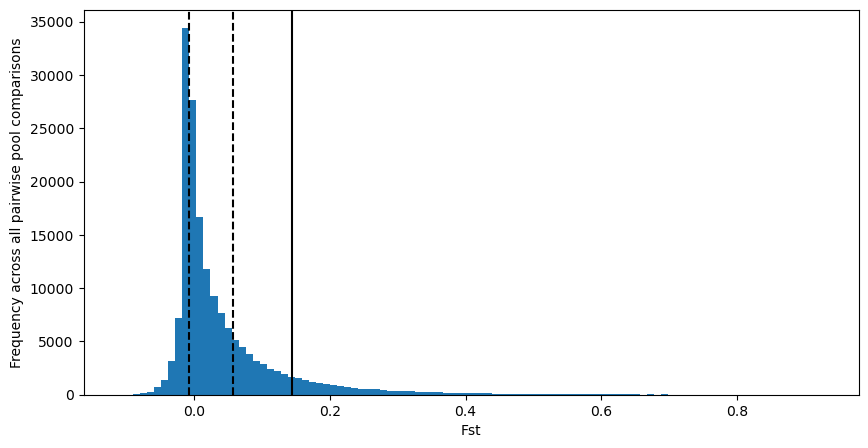

In [63]:
# distribution of Fst values across SNP positions and pairwise comparisons
fig,ax = plt.subplots(figsize = (10,5), facecolor = 'w')

ax.hist(data['multilocusfst'], bins=100)
ax.axvline(x = data['multilocusfst'].quantile(0.25), c = 'k', ls = '--')
ax.axvline(x = data['multilocusfst'].quantile(0.75), c = 'k', ls = '--')
ax.axvline(x = data['multilocusfst'].quantile(0.9), c = 'k')
plt.ylabel('Frequency across all pairwise pool comparisons')
plt.xlabel('Fst')
plt.show()

In [7]:
data['pair'].unique()

array(['pools12', 'pools13', 'pools14', 'pools23', 'pools24', 'pools34'],
      dtype=object)

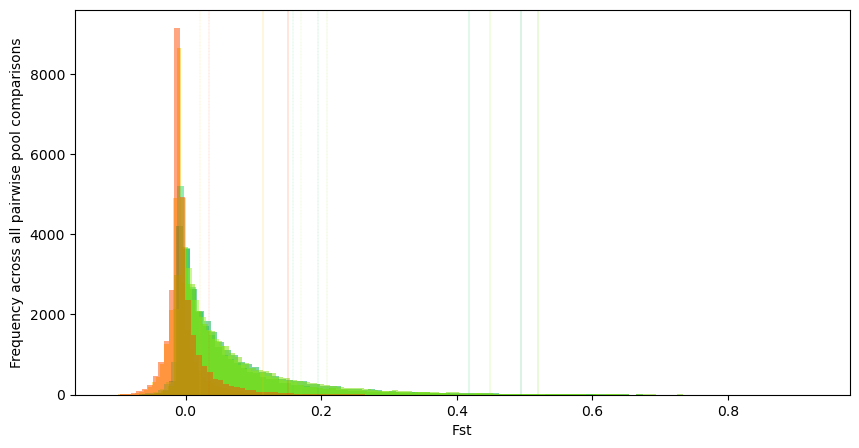

In [64]:
# colour dic with orange-hues for within morphotype comparisons and green-blue-ish hues for between morphotyes

paircol = {'pools12':'#FFC000',
           'pools13':'#24D86D',
           'pools14':'#00AC46',
           'pools23':'#98F229',
           'pools24':'#78DA00',
           'pools34':'#FF4C00'}

fig,ax = plt.subplots(figsize = (10,5), facecolor = 'w')

for pair in list(data['pair'].unique()):
    temp = data[data['pair'] == pair]
    ax.hist(temp['multilocusfst'], bins=100, color = paircol[pair], alpha = 0.5)
    ax.axvline(x = temp['multilocusfst'].quantile(0.90), c = paircol[pair], alpha = 0.6, ls = '--', lw = 0.2)
    ax.axvline(x = temp['multilocusfst'].quantile(0.99), c = paircol[pair], alpha = 1, lw = 0.2)
plt.ylabel('Frequency across all pairwise pool comparisons')
plt.xlabel('Fst')
plt.show()

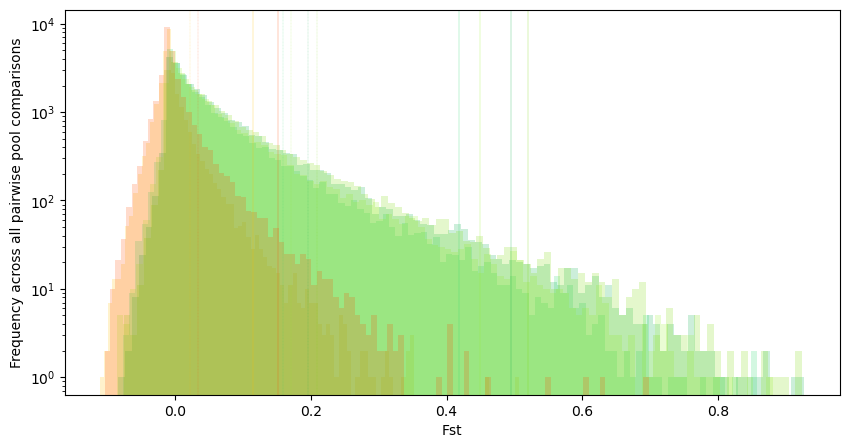

In [65]:
# colour dic with orange-hues for within morphotype comparisons and green-blue-ish hues for between morphotyes
fig,ax = plt.subplots(figsize = (10,5), facecolor = 'w')

for pair in list(data['pair'].unique()):
    temp = data[data['pair'] == pair]
    ax.hist(temp['multilocusfst'], bins=100, color = paircol[pair], alpha = 0.2, lw = 2)
    ax.axvline(x = temp['multilocusfst'].quantile(0.90), c = paircol[pair], alpha = 0.6, ls = '--', lw = 0.2)
    ax.axvline(x = temp['multilocusfst'].quantile(0.99), c = paircol[pair], alpha = 1, lw = 0.2)
ax.set_yscale('log')
plt.ylabel('Frequency across all pairwise pool comparisons')
plt.xlabel('Fst')
plt.show()

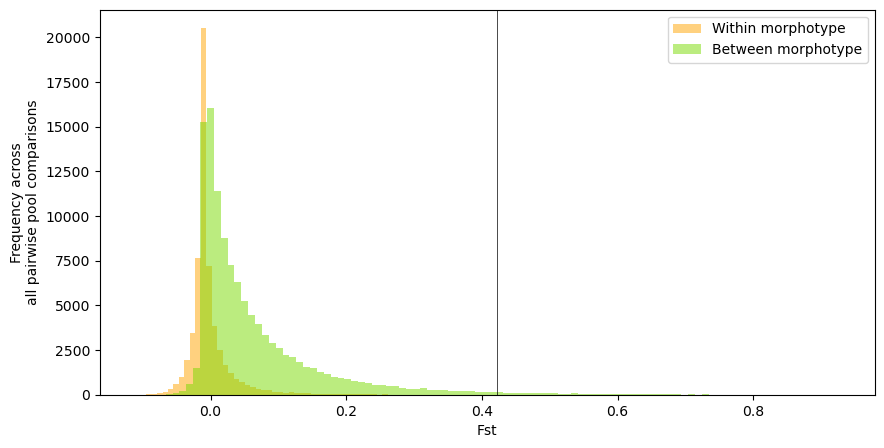

In [66]:
fig,ax = plt.subplots(figsize = (10,5), facecolor = 'w')

within = data[data['pair'].isin(['pools12','pools34'])]
between = data[data['pair'].isin(['pools13','pools14','pools23','pools24'])]

ax.hist(within['multilocusfst'], bins=100, color = '#FFA500', alpha = 0.5, label = 'Within morphotype')
ax.hist(between['multilocusfst'], bins=100, color = '#78DA00', alpha = 0.5, label = 'Between morphotype')

ax.axvline(x = data['multilocusfst'].quantile(0.99), c = 'k', alpha = 1, lw = 0.5)
plt.legend(loc = 'upper right', bbox_to_anchor = (0.5, 0.5, 0.5, 0.5))

plt.ylabel('Frequency across\nall pairwise pool comparisons')
plt.xlabel('Fst')
plt.show()

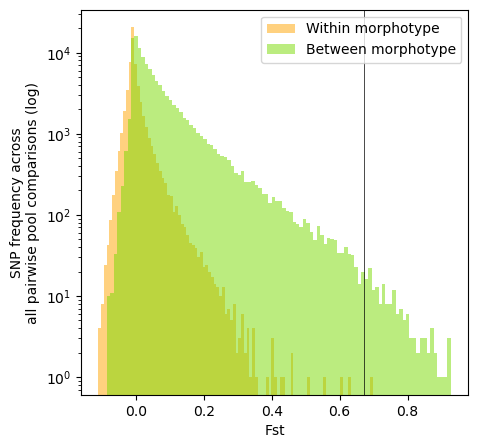

In [67]:
fig,ax = plt.subplots(figsize = (5,5), facecolor = 'w')

within = data[data['pair'].isin(['pools12','pools34'])]
between = data[data['pair'].isin(['pools13','pools14','pools23','pools24'])]

ax.hist(within['multilocusfst'], bins=100, color = '#FFA500', alpha = 0.5, label = 'Within morphotype')
ax.hist(between['multilocusfst'], bins=100, color = '#78DA00', alpha = 0.5, label = 'Between morphotype')

ax.axvline(x = data['multilocusfst'].quantile(0.999), c = 'k', alpha = 1, lw = 0.5)
ax.set_yscale('log')
plt.legend(loc = 'upper right', bbox_to_anchor = (0.5, 0.5, 0.5, 0.5))

plt.ylabel('SNP frequency across\nall pairwise pool comparisons (log)')
plt.xlabel('Fst')
plt.show()

In [68]:
print('Within Fst mean of %.3f and median of %.3f'%(within['multilocusfst'].mean(), within['multilocusfst'].median()))
print('Within Fst SD of %.3f'%(within['multilocusfst'].std()),'\n')

print('Between Fst mean of %.3f and median of %.3f'%(between['multilocusfst'].mean(), between['multilocusfst'].median()))
print('Between Fst SD of %.3f'%(between['multilocusfst'].std()),'\n')

Within Fst mean of -0.002 and median of -0.010
Within Fst SD of 0.033 

Between Fst mean of 0.065 and median of 0.029
Between Fst SD of 0.100 



## number of SNPs between and within morphotype comparisons

Do we chose as outliers anything beyond 95% of the distribution? (Salazar et al.) or beyond 90%? or with Fst >0.9 independently of the data distribution?

It makes more sense to choose outliers based on the quantiles rather than a numberical threshold (e.g. quantile 0.999 vs. Fst value >0.9) since the numerical thershold might not have any biological relevance. More so if we are studying within species populations (or very closely related, diverging new species).

It also makes sense to estimate the quantile from the distribution of all (within and between morphotype) Fst values, this way we capture the wide variation when within and between population dynamycs are both present. e.g. If I use the 0.99 quantile for only within-morphotype comparisons to identify outliers in within-morphotype comparisons I will undoubtly find something. It is less obvious for using pairwise-specific quantiles when comparing between-morphotype pools though, but using a pairwise-specific quantile in this case also undoubtly result in outliers. It is better to use a more "independent" value.

### Global

In [69]:
# SNPs with Fst values between -0.1 and 0.1 - effectively not relevant at all
data[(data['multilocusfst'] > -0.1) & (data['multilocusfst'] < 0.1)].groupby('pair').count()

,index,chr,cumulatedposition,multilocusfst,position
pair,,,,,
pools12,28073,28073,28073,28073,28073
pools13,23172,23172,23172,23172,23172
pools14,21667,21667,21667,21667,21667
pools23,22643,22643,22643,22643,22643
pools24,21019,21019,21019,21019,21019
pools34,27761,27761,27761,27761,27761


In [70]:
# SNPs with Fst values below the 0.9 threshold - effectively not relevant
data[data['multilocusfst'] < 0.9].groupby('pair').count()

,index,chr,cumulatedposition,multilocusfst,position
pair,,,,,
pools12,28454,28454,28454,28454,28454
pools13,28457,28457,28457,28457,28457
pools14,28455,28455,28455,28455,28455
pools23,28457,28457,28457,28457,28457
pools24,28454,28454,28454,28454,28454
pools34,28456,28456,28456,28456,28456


In [71]:
# SNPs with Fst values above or equal to the 0.9 threshold - interesting to look at
data[data['multilocusfst'] >= 0.9].groupby('pair').count()

,index,chr,cumulatedposition,multilocusfst,position
pair,,,,,
pools14,2,2,2,2,2
pools24,3,3,3,3,3


In [72]:
p090 = data['multilocusfst'].quantile(0.90)
p095 = data['multilocusfst'].quantile(0.95)
p099 = data['multilocusfst'].quantile(0.99)
p0999 = data['multilocusfst'].quantile(0.999)


print('Threshold value for the 0.9 quantile: %.3f'%(p090))
print('Threshold value for the 0.95 quantile: %.3f'%(p095))
print('Threshold value for the 0.99 quantile: %.3f'%(p099))
print('Threshold value for the 0.999 quantile: %.3f'%(p0999))

Threshold value for the 0.9 quantile: 0.143
Threshold value for the 0.95 quantile: 0.220
Threshold value for the 0.99 quantile: 0.422
Threshold value for the 0.999 quantile: 0.672


In [73]:
data[data['multilocusfst'] >= p090].groupby('pair').count()

,index,chr,cumulatedposition,multilocusfst,position
pair,,,,,
pools12,151,151,151,151,151
pools13,3322,3322,3322,3322,3322
pools14,4542,4542,4542,4542,4542
pools23,3722,3722,3722,3722,3722
pools24,5009,5009,5009,5009,5009
pools34,328,328,328,328,328


In [74]:
data[data['multilocusfst'] >= p095].groupby('pair').count()

,index,chr,cumulatedposition,multilocusfst,position
pair,,,,,
pools12,40,40,40,40,40
pools13,1589,1589,1589,1589,1589
pools14,2317,2317,2317,2317,2317
pools23,1904,1904,1904,1904,1904
pools24,2596,2596,2596,2596,2596
pools34,91,91,91,91,91


In [75]:
data[data['multilocusfst'] >= p0999].groupby('pair').count()

,index,chr,cumulatedposition,multilocusfst,position
pair,,,,,
pools13,19,19,19,19,19
pools14,52,52,52,52,52
pools23,30,30,30,30,30
pools24,69,69,69,69,69
pools34,1,1,1,1,1


In [20]:
data.columns

Index(['index', 'chr', 'cumulatedposition', 'multilocusfst', 'pair',
       'position'],
      dtype='object')

### Quantile thresholds by pairwise comparison

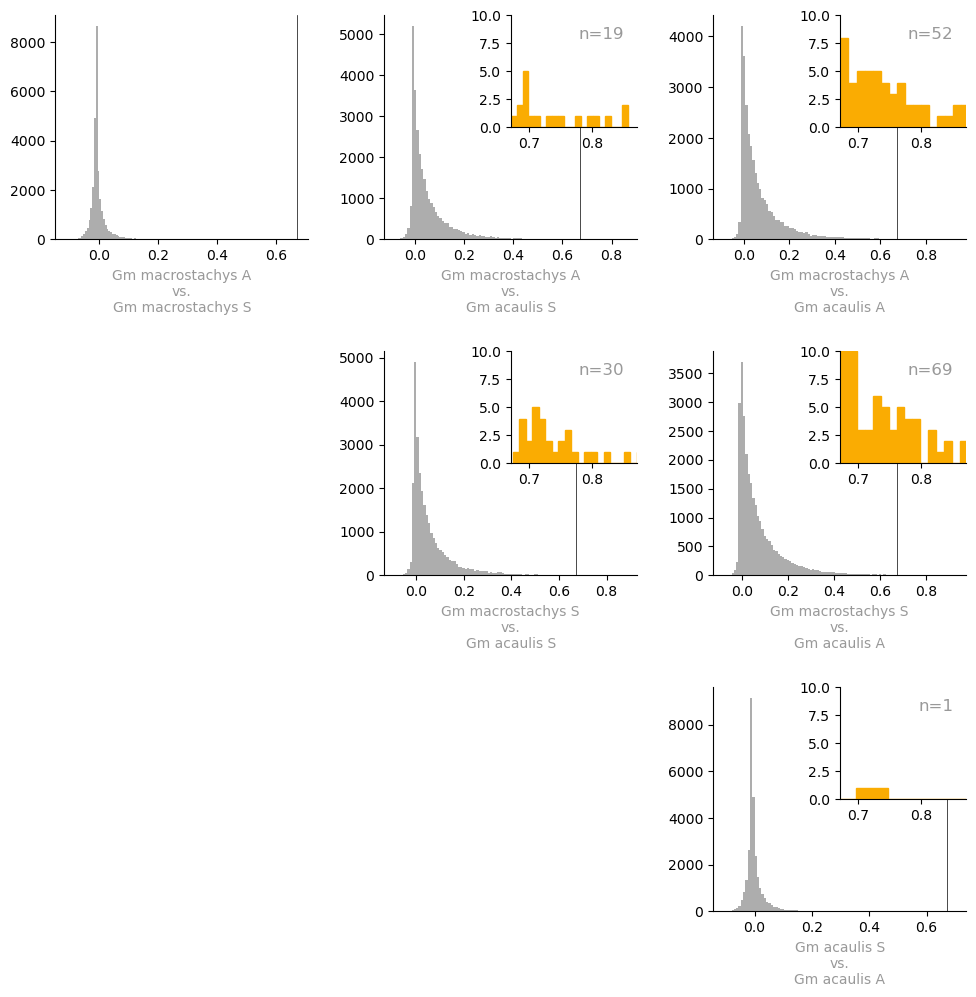

In [76]:
# we expect to find outliers in p1_p3, p2_p4, p1_p4, and p2_p3 that do not appear as outliers in p1_p2 or p3_p4
# we also need to understand the distribution of Fst values in each comparison

plt.figure(figsize=(4*4,4*4),facecolor='w')
G = gridspec.GridSpec(4,4,hspace=0.5,wspace=0.3)
spinescol='#999999'

labeldict = {'P13454_101':'Gm macrostachys A',
             'P13454_102':'Gm macrostachys S',
             'P13454_103':'Gm acaulis S',
             'P13454_104':'Gm acaulis A'}

plt.title('Distribution of pairwise Fst between pools')

alloutliers = pd.DataFrame(columns = ['index', 'chr', 'cumulatedposition', 'multilocusfst', 'pair', 'position'])

for x,y in combinations([i for i,x in enumerate(labeldict.keys())],2):
    ax = plt.subplot(G[x,y])
    temp = data[data['pair'] == 'pools%s%s'%(x+1,y+1)].copy(deep = True)
    outlier = temp[temp['multilocusfst'] >= p0999].copy(deep = True)
    alloutliers = pd.concat([alloutliers, outlier])
    
    ax.hist(data[data['pair'] == 'pools%s%s'%(x+1,y+1)]['multilocusfst'], bins = 100, color = '#adadad')      
    ax.axvline(x = p0999, c = 'k', alpha = 1, lw = 0.5)

    # I know, but I'm on a rush
    ax.set_xlabel('%s\nvs.\n%s'%(labeldict[list(labeldict.keys())[x]],labeldict[list(labeldict.keys())[y]]),
                  fontsize = 10, color = spinescol)

    [ax.spines[loc].set_visible(False) for loc in ['right','top']]

    if len(outlier) >= 1:
        ax1 = inset_axes(ax, width = '50%', height = '50%', loc = 1, borderpad = 0)
        ax1.hist(outlier['multilocusfst'], bins = 20, facecolor = '#faac02', edgecolor = '#faac02', lw = 1)
        ax1.set_ylim(0,10)
        ax1.set_xlim(p0999,p0999+0.2)
        ax1.vlines(x = 0.9, ymin = ax1.get_ylim()[0], ymax = ax1.get_ylim()[1], color = '#bababa', lw = 1)
        [ax1.spines[loc].set_visible(False) for loc in ['right','top']]

        ax1.text(0.9,0.9, s = 'n=%s'%(len(outlier)), fontsize = 12,ha='right',va='top', 
                 color = spinescol,transform=ax1.transAxes)

plt.show()

In [77]:
alloutliers.sort_values(['chr','cumulatedposition','pair'], inplace = True)
alloutliers.reset_index(inplace = True)
alloutliers

,level_0,index,chr,cumulatedposition,multilocusfst,pair,position
0,57749,835,NODE_103251_length_1585_cov_29.275817,48523738,0.731404,pools14,1472
1,114663,835,NODE_103251_length_1585_cov_29.275817,48523738,0.781356,pools24,1472
2,114664,836,NODE_103251_length_1585_cov_29.275817,48523767,0.691745,pools24,1501
3,86337,966,NODE_103957_length_1570_cov_25.852805,48630401,0.674653,pools23,1488
4,114883,1055,NODE_104226_length_1565_cov_22.646358,48689107,0.765209,pools24,1502
...,...,...,...,...,...,...,...
166,84402,27488,NODE_98688_length_1683_cov_23.089681,75982908,0.773380,pools14,1605
167,141316,27488,NODE_98688_length_1683_cov_23.089681,75982908,0.921059,pools24,1605
168,113559,28188,NW_011555567.1_RagTag_RagTag,84089756,0.719613,pools23,6271
169,142016,28188,NW_011555567.1_RagTag_RagTag,84089756,0.881519,pools24,6271


In [23]:
alloutliers.to_csv('./GM_SNPs_Fst_2023/alloutliers_20230802.txt', sep = '\t')

In [78]:
alloutliers = pd.read_csv('./GM_SNPs_Fst_2023/alloutliers_20230802.txt', sep = '\t')
alloutliers.drop(columns = 'Unnamed: 0', inplace = True)
alloutliers

,level_0,index,chr,cumulatedposition,multilocusfst,pair,position
0,57749,835,NODE_103251_length_1585_cov_29.275817,48523738,0.731404,pools14,1472
1,114663,835,NODE_103251_length_1585_cov_29.275817,48523738,0.781356,pools24,1472
2,114664,836,NODE_103251_length_1585_cov_29.275817,48523767,0.691745,pools24,1501
3,86337,966,NODE_103957_length_1570_cov_25.852805,48630401,0.674653,pools23,1488
4,114883,1055,NODE_104226_length_1565_cov_22.646358,48689107,0.765209,pools24,1502
...,...,...,...,...,...,...,...
166,84402,27488,NODE_98688_length_1683_cov_23.089681,75982908,0.773380,pools14,1605
167,141316,27488,NODE_98688_length_1683_cov_23.089681,75982908,0.921059,pools24,1605
168,113559,28188,NW_011555567.1_RagTag_RagTag,84089756,0.719613,pools23,6271
169,142016,28188,NW_011555567.1_RagTag_RagTag,84089756,0.881519,pools24,6271


In [79]:
print('Total number of outliers: ',len(alloutliers['chr'].unique()),'\n')
print('Chromosomes with outliers: ',[x for x in list(alloutliers['chr'].unique()) if 'RagTag_RagTag' in str(x)])

Total number of outliers:  95 

Chromosomes with outliers:  ['NW_011555567.1_RagTag_RagTag', 'NW_011561999.1_RagTag_RagTag']


In [80]:
cmap = mpl.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin = alloutliers['multilocusfst'].min(), vmax = alloutliers['multilocusfst'].max())
print(cmap(0.5))
print(norm(0.5))
print(cmap(norm((0.5))))

(0.127568, 0.566949, 0.550556, 1.0)
-0.6706241459598619
(0.267004, 0.004874, 0.329415, 1.0)


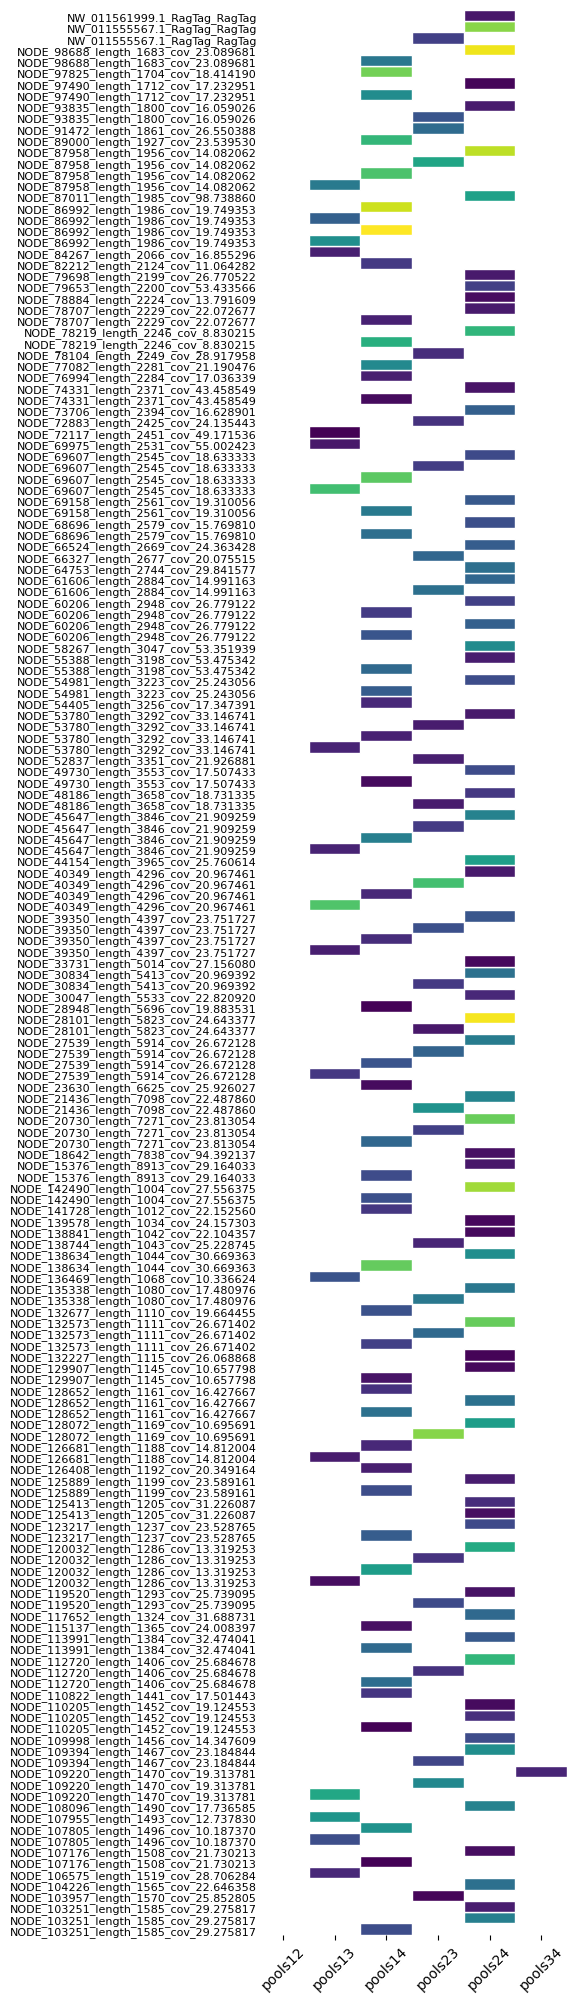

In [81]:
fig, ax = plt.subplots(figsize = (4,25), facecolor = 'w')

ax.set_ylim(0,len(alloutliers))
ax.set_xlim(0,len(data['pair'].unique()))

cmap = mpl.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin = alloutliers['multilocusfst'].min(), vmax = alloutliers['multilocusfst'].max())

for x, pair in enumerate(data['pair'].unique()):
    temp = alloutliers[alloutliers['pair'] == pair]
    if len(temp) >= 1:
        for y in temp.index:
            ax.add_patch(mpl.patches.Rectangle((x, y), 1, 1, edgecolor = 'w',
                        facecolor = cmap(norm(temp.loc[y,'multilocusfst'])))) # (bottom,left), width, height

for index,chrm in enumerate(alloutliers['chr']):
    ax.text(x = 0, y = index, s = chrm, ha = 'right', fontsize = 8)
[ax.spines[loc].set_visible(False) for loc in ['right','top','left','bottom']]

ax.set_xticklabels(data['pair'].unique(), fontdict = {'fontsize': 10, 'rotation':45})
ax.set_xticks([x+0.5 for x,pair in enumerate(data['pair'].unique())])

plt.yticks([])
plt.show()

In [28]:
# make a list of the outlier loci that contains the chromosome info and the position
alloutliers[['chr', 'position']].to_csv('./GM_SNPs_Fst_2023/outliers_0999_20230725.txt', sep ='\t')

In [29]:
%%bash
head ./GM_SNPs_Fst_2023/outliers_0999_20230725.txt

	chr	position
0	NODE_103251_length_1585_cov_29.275817	1472
1	NODE_103251_length_1585_cov_29.275817	1472
2	NODE_103251_length_1585_cov_29.275817	1501
3	NODE_103957_length_1570_cov_25.852805	1488
4	NODE_104226_length_1565_cov_22.646358	1502
5	NODE_106575_length_1519_cov_28.706284	1445
6	NODE_107176_length_1508_cov_21.730213	1465
7	NODE_107176_length_1508_cov_21.730213	1465
8	NODE_107805_length_1496_cov_10.187370	1423


In [82]:
# find sequences up and downstream from the SNPs in the reference sequence
toblast={}

for line in open('./GM_SNPs_Fst_2023/selected_contigs.fasta', 'r'):
    if '>' in line:
        if str(line).strip('\n').strip('>') in list(alloutliers['chr'].values):
            chrom = str(line).strip('\n').strip('>')

            poss = [x for x in set(alloutliers[alloutliers['chr'] == chrom]['position'].values)]
    # because there's no cases where a line with '>' won't be followed by a line without '>'
    # since the fasta sequence is a single line
    else:
        # here iterates through the different positions
        for pos in poss:
            toblast['%s_%s-1000'%(chrom,pos)] = line[pos-500:pos].strip('\n')+line[pos:pos+500].strip('\n')
#             print(line[pos-500:pos].strip('\n')+'--SNP--'+line[pos:pos+500].strip('\n'))

        poss = [] # empties the list
        chrom = []
toblast

{'NODE_103251_length_1585_cov_29.275817_1472-1000': 'GGTCTGCTTCAGCTATCGTGACTCGGTCGGCCCATGTTCGGGCCAGCTCCCGGCTGGCGACAAAGTTCTTGTCCAACGATAACAAGTTATGGGAAAACTGCACAAGAAGGTAAAAGTTAGTCAGAACTATATTAATTTGATTGGCTAGTTGATCAAGAGATACTTACGGAGATCAGCACGGTGAATGACTGGGAGAGAATCTCCTCCGCTGGCCTCGACCGTAGATTTGCTTCATCCTGCGGCATGACCATCATCGCTGCTAGCCGGCGAGCCAGCTCCAGGTTCGCAATGGCCGAGTCAGTCGGATTGATCCATATGCTATGGTAGAATGGCTGGTCCGGTTGGCGCCCAGTATTTGAAGTCGGCCCGGGACCGACTGATGCTGATGTTGACGGGGTCGGAGTCGGTGTTCGGGACGATCGAGCGGTGGCGGGTGCCGGGACACTTGGCTCCGCAGCGACAGCCTCATCATCAACTGCTGCTGGAGGTGGACGGCTGGTCAGCGCACTCGGTGCGGCCAACCCGACTACTGGATCTCGGCCCCGATTGGACGGGCCAGATGTCGTCTGCTTCTTCTTCTTCTTCCAAGGGGGCTCACTCGGCTCAGCCCCCG',
 'NODE_103251_length_1585_cov_29.275817_1501-1000': 'GCCCATGTTCGGGCCAGCTCCCGGCTGGCGACAAAGTTCTTGTCCAACGATAACAAGTTATGGGAAAACTGCACAAGAAGGTAAAAGTTAGTCAGAACTATATTAATTTGATTGGCTAGTTGATCAAGAGATACTTACGGAGATCAGCACGGTGAATGACTGGGAGAGAATCTCCTCCGCTGGCCTCGACCGTAGATTTGCTTCATCCTGCGGCATGACCATCATCGCTGCTAGCCGGCGAGCCAGCTCCAGGTTCGCAATGGCCGAGTCAGTCGGAT

In [99]:
path = './GM_SNPs_Fst_2023/'
new_fasta = open(os.path.join(path,'SNP1000_wseqs.fasta'),'a')

for key,value in toblast.items():
    header = re.sub('_[0-9]+$','',key.split('-1000')[0])
    # print header
    new_fasta.write('>%s\n'%(header))
    # print sequence, line ending was removed already
    new_fasta.write('%s\n'%(value))
new_fasta.close()

In [37]:
for contig,seq in toblast.items():
    if path.exists('./GM_SNPs_Fst_2023/results_blastn/%s_blastn_nt.xml'%(contig)) == True:
        print('Processed: ','./GM_SNPs_Fst_2023/results_blastn/%s_blastn_nt.xml'%(contig))
    else:
    
        result_handle = NCBIWWW.qblast('blastn', 'nt', seq, entrez_query = 'txid35493[ORGN]',
                                       alignments = 100, hitlist_size=100)
        print('Processing: ', contig)

        with open('./GM_SNPs_Fst_2023/results_blastn/%s_blastn_nt.xml'%(contig), 'w') as save_file:
            blast_results = result_handle.read() 
            save_file.write(blast_results)
            save_file.close()

            result_handle.close()
        time.sleep(0.5) # dont want to be kicked out  

Processing:  NODE_103251_length_1585_cov_29.275817_1472-1000
Processing:  NODE_103251_length_1585_cov_29.275817_1501-1000
Processing:  NODE_103957_length_1570_cov_25.852805_1488-1000
Processing:  NODE_104226_length_1565_cov_22.646358_1502-1000
Processing:  NODE_106575_length_1519_cov_28.706284_1445-1000
Processing:  NODE_107176_length_1508_cov_21.730213_1465-1000
Processing:  NODE_107805_length_1496_cov_10.187370_1423-1000
Processing:  NODE_107955_length_1493_cov_12.737830_1414-1000
Processing:  NODE_108096_length_1490_cov_17.736585_1407-1000
Processing:  NODE_109220_length_1470_cov_19.313781_1388-1000
Processing:  NODE_109394_length_1467_cov_23.184844_1393-1000
Processing:  NODE_109998_length_1456_cov_14.347609_1391-1000
Processing:  NODE_110205_length_1452_cov_19.124553_1405-1000
Processing:  NODE_110205_length_1452_cov_19.124553_1367-1000
Processing:  NODE_110822_length_1441_cov_17.501443_1376-1000
Processing:  NODE_112720_length_1406_cov_25.684678_1330-1000
Processing:  NODE_113991

In [38]:
for contig,seq in toblast.items():
    if path.exists('./GM_SNPs_Fst_2023/results_blastx/%s_blastx_nr.xml'%(contig)) == True:
        print('Processed: ','./GM_SNPs_Fst_2023/results_blastx/%s_blastx_nr.xml'%(contig))
    else:
    
        result_handle = NCBIWWW.qblast('blastx', 'nr', seq, filter = 'txid35493[ORGN]', alignments = 100, hitlist_size=100)
        print('Processing: ', contig)

        with open('./GM_SNPs_Fst_2023/results_blastx/%s_blastx_nr.xml'%(contig), 'w') as save_file:
            blast_results = result_handle.read() 
            save_file.write(blast_results)
            save_file.close()

            result_handle.close()
        time.sleep(0.5) # dont want to be kicked out  

Processing:  NODE_103251_length_1585_cov_29.275817_1472-1000
Processing:  NODE_103251_length_1585_cov_29.275817_1501-1000
Processing:  NODE_103957_length_1570_cov_25.852805_1488-1000
Processing:  NODE_104226_length_1565_cov_22.646358_1502-1000
Processing:  NODE_106575_length_1519_cov_28.706284_1445-1000
Processing:  NODE_107176_length_1508_cov_21.730213_1465-1000
Processing:  NODE_107805_length_1496_cov_10.187370_1423-1000
Processing:  NODE_107955_length_1493_cov_12.737830_1414-1000
Processing:  NODE_108096_length_1490_cov_17.736585_1407-1000
Processing:  NODE_109220_length_1470_cov_19.313781_1388-1000
Processing:  NODE_109394_length_1467_cov_23.184844_1393-1000
Processing:  NODE_109998_length_1456_cov_14.347609_1391-1000
Processing:  NODE_110205_length_1452_cov_19.124553_1405-1000
Processing:  NODE_110205_length_1452_cov_19.124553_1367-1000
Processing:  NODE_110822_length_1441_cov_17.501443_1376-1000
Processing:  NODE_112720_length_1406_cov_25.684678_1330-1000
Processing:  NODE_113991

In [ ]:
%%bash
ls ./GM_SNPs_Fst_2023/results_blastn/

In [43]:
folder_path = './GM_SNPs_Fst_2023/results_blastn/'
prefix  ='*xml'

# iterate over files in
# that directory
columns = ['contig','result_id','hsp_id','hsp_evalue','hsp_bitscore','hsp_gapnum','hsp_range','hsp_description']
blastnall = pd.DataFrame(columns = columns)

    
for filename in glob.glob(os.path.join(folder_path,'%s'%(prefix))):
#     print(filename)
    result = SearchIO.read(filename, 'blast-xml')
    
    contig = []
    result_id = []
    hsp_id = []
    hsp_evalue = []
    hsp_bitscore = []
    hsp_gapnum = []
    hsp_range = []
    hsp_description = []

    for hsp in result.hsps:
        if hsp.evalue < 0.00005:
            contig.append(filename.split('/')[-1].split('.xml')[0])
            result_id.append(result.blast_id)
            hsp_id.append(hsp.hit_id)
            hsp_evalue.append(hsp.evalue)
            hsp_bitscore.append(hsp.bitscore)
            hsp_gapnum.append(hsp.gap_num)
            hsp_range.append(hsp.hit_range)
            hsp_description.append(hsp.hit_description)
            
#             print(hsp_description)
#             time.sleep(0.5)
    if len(contig) >= 1:
        temp = pd.DataFrame(dict(zip(columns,[contig,result_id,hsp_id,hsp_evalue,hsp_bitscore,hsp_gapnum,hsp_range,hsp_description])))
        blastnall = pd.concat([blastnall,temp])

blastnall

,contig,result_id,hsp_id,hsp_evalue,hsp_bitscore,hsp_gapnum,hsp_range,hsp_description
0,NODE_107955_length_1493_cov_12.737830_1414-100...,Query_32277,gi|2306609436|emb|OX335795.1|,2.849580e-18,104.9800,8,"(630640, 630750)","Scutellaria galericulata genome assembly, chro..."
1,NODE_107955_length_1493_cov_12.737830_1414-100...,Query_32277,gi|2306609436|emb|OX335795.1|,7.646480e-13,86.9463,0,"(632916, 632971)","Scutellaria galericulata genome assembly, chro..."
2,NODE_107955_length_1493_cov_12.737830_1414-100...,Query_32277,gi|1477771530|gb|CP025657.1|,2.849580e-18,104.0780,0,"(1090965, 1091022)",Ipomoea trifida cultivar NCNSP0306 chromosome 14
3,NODE_107955_length_1493_cov_12.737830_1414-100...,Query_32277,gi|1477771530|gb|CP025657.1|,9.315310e-12,83.3396,0,"(480743, 480791)",Ipomoea trifida cultivar NCNSP0306 chromosome 14
4,NODE_107955_length_1493_cov_12.737830_1414-100...,Query_32277,gi|1477771528|gb|CP025655.1|,2.849580e-18,104.0780,0,"(18225893, 18225950)",Ipomoea trifida cultivar NCNSP0306 chromosome 12
...,...,...,...,...,...,...,...,...
1956,NW_011561999.1_RagTag_RagTag_10411-1000_blastn_nt,Query_27701,gi|2546768688|emb|OY288261.1|,8.611940e-06,63.5025,0,"(45542972, 45543069)","Agrostemma githago genome assembly, chromosome..."
1957,NW_011561999.1_RagTag_RagTag_10411-1000_blastn_nt,Query_27701,gi|2546768688|emb|OY288261.1|,8.611940e-06,62.6008,2,"(17698799, 17698901)","Agrostemma githago genome assembly, chromosome..."
1958,NW_011561999.1_RagTag_RagTag_10411-1000_blastn_nt,Query_27701,gi|2546768688|emb|OY288261.1|,8.611940e-06,62.6008,2,"(18679448, 18679550)","Agrostemma githago genome assembly, chromosome..."
1959,NW_011561999.1_RagTag_RagTag_10411-1000_blastn_nt,Query_27701,gi|2546768688|emb|OY288261.1|,3.005860e-05,61.6992,4,"(4095293, 4095395)","Agrostemma githago genome assembly, chromosome..."


In [44]:
# exploring the distribution of escores and bitscores
blastnall['hsp_ln'] = [x[1]-x[0] for x in blastnall['hsp_range']]
blastnall['hsp_gapnum'] = blastnall['hsp_gapnum'].astype('float')
blastnall[['hsp_evalue','hsp_bitscore','hsp_gapnum','hsp_ln']].describe()

,hsp_evalue,hsp_bitscore,hsp_gapnum,hsp_ln
count,5.120200e+04,51202.000000,51202.000000,51202.000000
mean,1.504098e-06,115.928067,5.929124,336.009218
std,5.793104e-06,47.838982,6.427143,170.245094
min,0.000000e+00,60.797500,0.000000,34.000000
25%,9.405820e-31,77.027800,0.000000,153.000000
50%,9.817540e-18,102.275000,4.000000,339.000000
75%,4.041360e-10,145.556000,9.000000,509.000000
max,3.140540e-05,774.030000,65.000000,597.000000


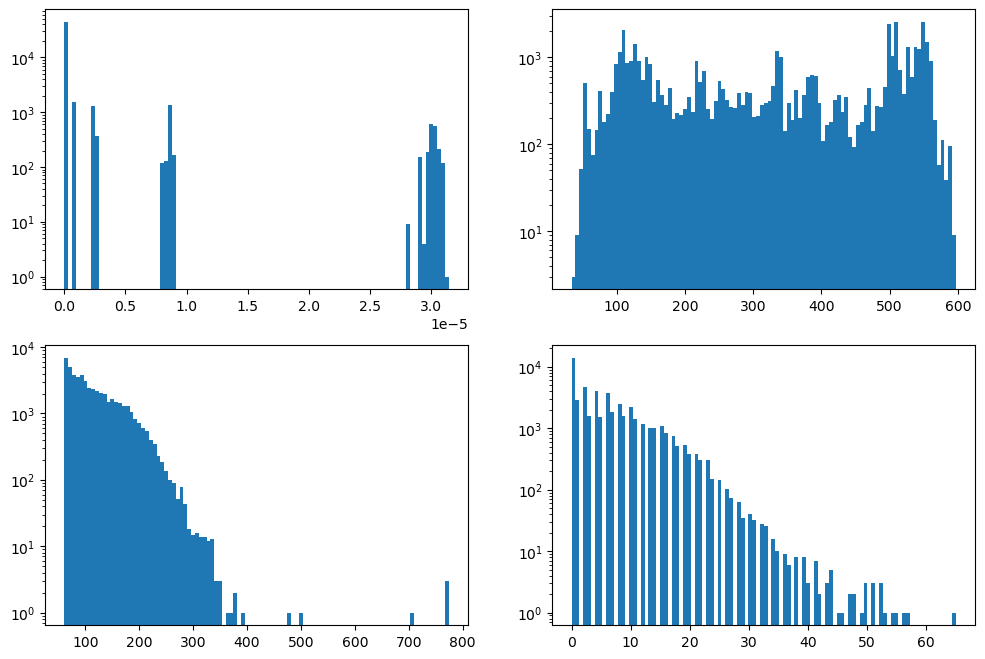

In [34]:
fix, axs = plt.subplots(2,2, figsize = (12,8), sharey=False, facecolor = 'w')

axs[0, 0].hist(blastnall['hsp_evalue'], bins = 100, log = True)
axs[1, 0].hist(blastnall['hsp_bitscore'], bins = 100, log = True)

axs[0, 1].hist([x[1]-x[0] for x in blastnall['hsp_range']],
               bins = 100, log = True)
axs[1, 1].hist(blastnall['hsp_gapnum'], bins = 100, log = True)

plt.show()

In [48]:
# we need to identify the best hit for each of the contigs
# the best is to sort values by evalue (ascending == true), length (asc = False), gaps (asc = True)
# then taking the first three records by contig and removing the rest

blastnall.sort_values(by = ['hsp_evalue','hsp_ln','hsp_gapnum'], ascending = [True, False, True]).reset_index(inplace = True)

# in case there are duplicates
blastnallfilt = blastnall.drop_duplicates(subset = ['contig','hsp_description','hsp_evalue'], keep = 'first')

best3blastn = pd.DataFrame(columns = blastnall.columns)

for contig in blastnallfilt['contig'].unique():
    temp = blastnallfilt[blastnallfilt['contig'] == contig].head(3)
    best3blastn = pd.concat([best3blastn, temp])

# uniqblastnall = blastnall.drop_duplicates(subset = 'contig', keep = 'first').reset_index()
# uniqblastnall
best3blastn

,contig,result_id,hsp_id,hsp_evalue,hsp_bitscore,hsp_gapnum,hsp_range,hsp_description,hsp_ln
0,NODE_107955_length_1493_cov_12.737830_1414-100...,Query_32277,gi|2306609436|emb|OX335795.1|,2.849580e-18,104.9800,8.0,"(630640, 630750)","Scutellaria galericulata genome assembly, chro...",110
1,NODE_107955_length_1493_cov_12.737830_1414-100...,Query_32277,gi|2306609436|emb|OX335795.1|,7.646480e-13,86.9463,0.0,"(632916, 632971)","Scutellaria galericulata genome assembly, chro...",55
2,NODE_107955_length_1493_cov_12.737830_1414-100...,Query_32277,gi|1477771530|gb|CP025657.1|,2.849580e-18,104.0780,0.0,"(1090965, 1091022)",Ipomoea trifida cultivar NCNSP0306 chromosome 14,57
0,NODE_108096_length_1490_cov_17.736585_1407-100...,Query_26347,gi|1658070146|ref|XR_003799069.1|,3.054150e-100,376.3870,4.0,"(1874, 2244)",PREDICTED: Elaeis guineensis protein GLUTELIN ...,370
1,NODE_108096_length_1490_cov_17.736585_1407-100...,Query_26347,gi|1658070146|ref|XR_003799069.1|,5.190180e-15,94.1598,0.0,"(2231, 2320)",PREDICTED: Elaeis guineensis protein GLUTELIN ...,89
...,...,...,...,...,...,...,...,...,...
1,NODE_98688_length_1683_cov_23.089681_1605-1000...,Query_27599,gi|2546768122|emb|OY288240.1|,3.953460e-10,77.0278,6.0,"(11091861, 11092082)","Agrostemma githago genome assembly, chromosome: 2",221
2,NODE_98688_length_1683_cov_23.089681_1605-1000...,Query_27599,gi|2546768122|emb|OY288240.1|,4.816300e-09,74.3227,6.0,"(14625744, 14625966)","Agrostemma githago genome assembly, chromosome: 2",222
0,NW_011561999.1_RagTag_RagTag_10411-1000_blastn_nt,Query_27701,gi|1446104449|gb|MH680964.1|,1.893560e-39,175.3110,1.0,"(180013, 180434)",Phoenix dactylifera clone dpBLOGautosomal2 sex...,421
1,NW_011561999.1_RagTag_RagTag_10411-1000_blastn_nt,Query_27701,gi|1446107009|gb|MH681002.1|,3.423630e-36,164.4910,0.0,"(587515, 587968)",Phoenix dactylifera clone dpB2Y sex-determinat...,453


In [49]:
# best3blastn[['contig','hsp_description', 'hsp_evalue']].sort_values(by = 'hsp_evalue', ascending = True)
best3blastn.sort_values(by = 'hsp_evalue', ascending = True)['hsp_description'].values

array(['PREDICTED: Elaeis guineensis probable LRR receptor-like serine/threonine-protein kinase At3g47570 (LOC105036214), transcript variant X2, mRNA',
       'PREDICTED: Elaeis guineensis probable LRR receptor-like serine/threonine-protein kinase At3g47570 (LOC105036214), transcript variant X1, mRNA',
       'PREDICTED: Elaeis guineensis probable LRR receptor-like serine/threonine-protein kinase At3g47570 (LOC105032866), mRNA',
       'PREDICTED: Elaeis guineensis protein GLUTELIN PRECURSOR ACCUMULATION 3 (LOC105034327), transcript variant X2, misc_RNA',
       'PREDICTED: Elaeis guineensis protein GLUTELIN PRECURSOR ACCUMULATION 3 (LOC105034327), transcript variant X1, misc_RNA',
       'Ananas comosus genome assembly, chromosome: 18',
       'Ananas comosus var. bracteatus genome assembly, chromosome: 18',
       'Quercus robur genome assembly, chromosome: 5',
       'Quercus robur genome assembly, chromosome: 10',
       'Quercus robur genome assembly, chromosome: 5',
       'Querc

In [57]:
best3blastn.to_csv('./GM_SNPs_Fst_2023/results_blastn/best_hsps_contigs_blastn_20230802.txt', sep = '\t')

In [52]:
folder_path = './GM_SNPs_Fst_2023/results_blastx/'
prefix  ='*xml'

# iterate over files in
# that directory
columns = ['contig','result_id','hsp_id','hsp_evalue','hsp_bitscore','hsp_gapnum','hsp_range','hsp_description']
blastxall = pd.DataFrame(columns = columns)

    
for filename in glob.glob(os.path.join(folder_path,'%s'%(prefix))):
#     print(filename)
    result = SearchIO.read(filename, 'blast-xml')
    
    contig = []
    result_id = []
    hsp_id = []
    hsp_evalue = []
    hsp_bitscore = []
    hsp_gapnum = []
    hsp_range = []
    hsp_description = []

    for hsp in result.hsps:
        if hsp.evalue < 0.00005:
            contig.append(filename.split('/')[-1].split('.xml')[0])
            result_id.append(result.blast_id)
            hsp_id.append(hsp.hit_id)
            hsp_evalue.append(hsp.evalue)
            hsp_bitscore.append(hsp.bitscore)
            hsp_gapnum.append(hsp.gap_num)
            hsp_range.append(hsp.hit_range)
            hsp_description.append(hsp.hit_description)
            
#             print(hsp_description)
#             time.sleep(0.5)
    if len(contig) >= 1:
        temp = pd.DataFrame(dict(zip(columns,[contig,result_id,hsp_id,hsp_evalue,hsp_bitscore,hsp_gapnum,hsp_range,hsp_description])))
        blastxall = pd.concat([blastxall,temp])

blastxall

,contig,result_id,hsp_id,hsp_evalue,hsp_bitscore,hsp_gapnum,hsp_range,hsp_description
0,NODE_108096_length_1490_cov_17.736585_1407-100...,Query_4787,ref|XP_057955072.1|,7.310400e-09,56.6102,5,"(10, 78)",uncharacterized protein LOC131149045 [Malania ...
1,NODE_108096_length_1490_cov_17.736585_1407-100...,Query_4787,ref|XP_057955072.1|,7.310400e-09,33.1130,8,"(77, 121)",uncharacterized protein LOC131149045 [Malania ...
2,NODE_108096_length_1490_cov_17.736585_1407-100...,Query_4787,ref|XP_010914753.1|,1.725080e-07,51.2174,0,"(4, 55)",uncharacterized protein LOC105040079 [Elaeis g...
3,NODE_108096_length_1490_cov_17.736585_1407-100...,Query_4787,ref|XP_010914753.1|,1.725080e-07,33.8834,0,"(56, 86)",uncharacterized protein LOC105040079 [Elaeis g...
4,NODE_108096_length_1490_cov_17.736585_1407-100...,Query_4787,ref|XP_057966041.1|,6.493370e-07,51.6026,5,"(10, 83)",uncharacterized protein LOC131156404 [Malania ...
...,...,...,...,...,...,...,...,...
96,NW_011561999.1_RagTag_RagTag_10411-1000_blastx_nr,Query_9483,ref|XP_009413782.1|,7.901350e-65,228.0240,0,"(1392, 1582)",PREDICTED: uncharacterized protein LOC10399502...
97,NW_011561999.1_RagTag_RagTag_10411-1000_blastx_nr,Query_9483,gb|KAJ4715162.1|,8.361040e-65,227.6390,0,"(1356, 1546)",Retrovirus-related Pol polyprotein from transp...
98,NW_011561999.1_RagTag_RagTag_10411-1000_blastx_nr,Query_9483,ref|XP_030941624.1|,8.738500e-65,216.8530,0,"(260, 449)",uncharacterized protein LOC115966552 [Quercus ...
99,NW_011561999.1_RagTag_RagTag_10411-1000_blastx_nr,Query_9483,dbj|GMH25591.1|,9.759810e-65,220.7050,0,"(235, 425)",hypothetical protein Nepgr_027434 [Nepenthes g...


In [53]:
# exploring the distribution of escores and bitscores
blastxall['hsp_ln'] = [x[1]-x[0] for x in blastxall['hsp_range']]
blastxall['hsp_gapnum'] = blastxall['hsp_gapnum'].astype('float')
blastxall[['hsp_evalue','hsp_bitscore','hsp_gapnum','hsp_ln']].describe()

,hsp_evalue,hsp_bitscore,hsp_gapnum,hsp_ln
count,4.001000e+03,4001.000000,4001.000000,4001.000000
mean,9.714442e-07,121.355863,4.672832,129.340165
std,5.112506e-06,70.363424,7.511470,52.174112
min,1.718560e-97,20.786600,0.000000,13.000000
25%,1.331560e-49,64.314200,0.000000,77.000000
50%,4.340720e-26,100.138000,1.000000,140.000000
75%,3.477020e-14,168.318000,6.000000,182.000000
max,4.993380e-05,315.464000,56.000000,218.000000


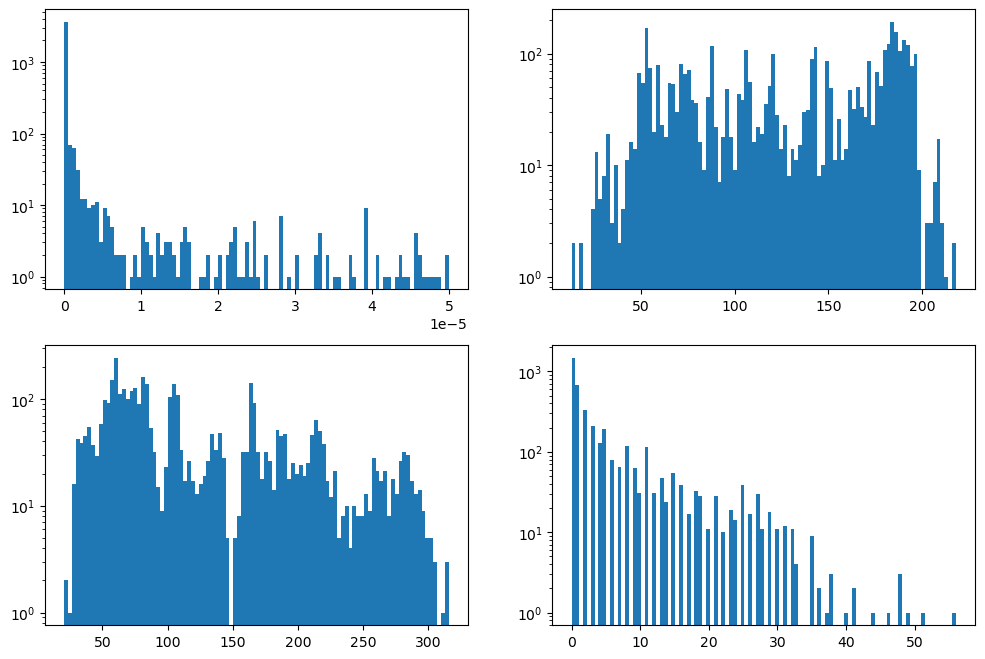

In [54]:
fix, axs = plt.subplots(2,2, figsize = (12,8), sharey=False, facecolor = 'w')

axs[0, 0].hist(blastxall['hsp_evalue'], bins = 100, log = True)
axs[1, 0].hist(blastxall['hsp_bitscore'], bins = 100, log = True)

axs[0, 1].hist([x[1]-x[0] for x in blastxall['hsp_range']],
               bins = 100, log = True)
axs[1, 1].hist(blastxall['hsp_gapnum'], bins = 100, log = True)

plt.show()

In [55]:
# we need to identify the best hit for each of the contigs
# the best is to sort values by evalue (ascending == true), length (asc = False), gaps (asc = True)
# then taking the first three records by contig and removing the rest

blastxall.sort_values(by = ['hsp_evalue','hsp_ln','hsp_gapnum'], ascending = [True, False, True]).reset_index(inplace = True)

# in case there are duplicates
blastxallfilt = blastxall.drop_duplicates(subset = ['contig','hsp_description','hsp_evalue'], keep = 'first')

best3blastx = pd.DataFrame(columns = blastxall.columns)

for contig in blastxallfilt['contig'].unique():
    temp = blastxallfilt[blastxallfilt['contig'] == contig].head(3)
    best3blastx = pd.concat([best3blastx, temp])

# uniqblastnall = blastnall.drop_duplicates(subset = 'contig', keep = 'first').reset_index()
# uniqblastnall
best3blastx

,contig,result_id,hsp_id,hsp_evalue,hsp_bitscore,hsp_gapnum,hsp_range,hsp_description,hsp_ln
0,NODE_108096_length_1490_cov_17.736585_1407-100...,Query_4787,ref|XP_057955072.1|,7.310400e-09,56.6102,5.0,"(10, 78)",uncharacterized protein LOC131149045 [Malania ...,68
2,NODE_108096_length_1490_cov_17.736585_1407-100...,Query_4787,ref|XP_010914753.1|,1.725080e-07,51.2174,0.0,"(4, 55)",uncharacterized protein LOC105040079 [Elaeis g...,51
4,NODE_108096_length_1490_cov_17.736585_1407-100...,Query_4787,ref|XP_057966041.1|,6.493370e-07,51.6026,5.0,"(10, 83)",uncharacterized protein LOC131156404 [Malania ...,73
0,NODE_109220_length_1470_cov_19.313781_1388-100...,Query_103961,gb|KAG1368370.1|,2.408330e-11,73.9442,3.0,"(1, 103)",hypothetical protein COCNU_14G008380 [Cocos nu...,102
1,NODE_109220_length_1470_cov_19.313781_1388-100...,Query_103961,ref|XP_029123308.1|,1.147690e-10,72.0182,5.0,"(135, 237)",uncharacterized protein LOC114914669 [Elaeis g...,102
...,...,...,...,...,...,...,...,...,...
1,NODE_98688_length_1683_cov_23.089681_1605-1000...,Query_26253,gb|KAG1359359.1|,1.273300e-59,213.0010,0.0,"(777, 964)",hypothetical protein COCNU_08G008050 [Cocos nu...,187
2,NODE_98688_length_1683_cov_23.089681_1605-1000...,Query_26253,gb|EHA8589492.1|,1.297990e-59,213.0010,0.0,"(653, 840)",hypothetical protein [Cocos nucifera],187
0,NW_011561999.1_RagTag_RagTag_10411-1000_blastx_nr,Query_9483,gb|KAG1358790.1|,1.622250e-82,263.4620,0.0,"(114, 304)",putative Rve domain-containing protein [Cocos ...,190
1,NW_011561999.1_RagTag_RagTag_10411-1000_blastx_nr,Query_9483,gb|KAG1359359.1|,4.031720e-78,265.3880,0.0,"(958, 1148)",hypothetical protein COCNU_08G008050 [Cocos nu...,190


In [58]:
best3blastx.sort_values(by = 'hsp_evalue', ascending = True)['hsp_description'].values

array(['probable LRR receptor-like serine/threonine-protein kinase At3g47570 [Elaeis guineensis]',
       'hypothetical protein KFK09_018050 [Dendrobium nobile]',
       'RNA-directed DNA polymerase [Dendrobium catenatum]',
       'hypothetical protein [Cocos nucifera]',
       'hypothetical protein COCNU_11G005880 [Cocos nucifera]',
       'RNA-directed DNA polymerase [Dendrobium catenatum]',
       'putative RVT_1 domain-containing protein [Cocos nucifera]',
       'hypothetical protein COCNU_08G008050 [Cocos nucifera]',
       'hypothetical protein [Cocos nucifera]',
       'hypothetical protein COCNU_08G008050 [Cocos nucifera]',
       'putative Rve domain-containing protein [Cocos nucifera]',
       'hypothetical protein COCNU_08G008050 [Cocos nucifera]',
       'hypothetical protein [Cocos nucifera]',
       'uncharacterized protein LOC115950037 [Quercus lobata]',
       'uncharacterized protein LOC126710116 [Quercus robur]',
       'uncharacterized protein LOC126728462 [Quercus 

In [ ]:
best3blastx.to_csv('./GM_SNPs_Fst_2023/results_blastx/best_hsps_contigs_blastx_20230802.txt', sep = '\t')